In [1]:
import os 
#set working directory
os.chdir("../")
print(os.getcwd())

/Users/bguenes/Documents/Uni/Master/Masterarbeit


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from scipy.stats import norm
from scipy.stats import multivariate_normal
from tqdm import tqdm

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

from plot_functions import *

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dat = np.load('ChempyMulti/tutorial_data/Inference_Output.npz', allow_pickle=True)

# Extract the lambda values and n-stars
all_Lambdas = dat.f.Lambdas
n_stars = dat.f.n_stars

# Here we compute the statistical variances, averaged across realizations with the same value of n-stars
med,lo,up,lo2,up2,sample_lo,sample_hi=[np.zeros((len(n_stars),2)) for _ in range(7)]
for i in range(len(n_stars)):
    # Select only the Lambda estimates for this value of n-stars
    theseL=all_Lambdas[i]
    # Now compute the median, 1- and 2-sigma parameter ranges from the output chains for each realization using this n-stars.
    lowL2,lowL,medianL,upL,upL2 = [[np.percentile(L,p,axis=0) for L in theseL] for p in [2.275,15.865,50.,84.135,97.725]]
    # Take the average over all realizations
    up[i]=np.median(upL,axis=0)
    lo[i]=np.median(lowL,axis=0)
    up2[i]=np.median(upL2,axis=0)
    lo2[i]=np.median(lowL2,axis=0)
    med[i]=np.median(medianL,axis=0)

In [4]:
# --- Load simulated data ---
alpha_IMF_obs = np.load("master_thesis/data/alpha_IMF_obs.npy")
log10_N_Ia_obs = np.load("master_thesis/data/log10_N_Ia_obs.npy")
simulations = 1000
N_stars = 1000
global_params = torch.tensor([[-2.3, -2.89]])

In [7]:
def n_stars_plot_comp(x1, x2, x_true, no_stars= np.array([1, 10, 100, 500, 1000]), simulations=1000):
    fit = []
    err = []

    # --- Fit a 2D Gaussian to the data ---
    for n in no_stars:
        samples = int(n*simulations)
        N_stars = int(samples/simulations)
        mean_1, err_1, _ = mean_error(x1[0:samples], N_stars)
        mean_2, err_2, _ = mean_error(x2[0:samples], N_stars)

        fit.append([mean_1, mean_2])
        err.append([err_1, err_2])
        

    fit = np.array(fit)
    err = np.array(err)

    # --- Plot the data ---
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(26,6))

    def plot(fit, err, x_true, ax, name):
        ax.plot(no_stars, fit, color="b", label="Fit")
        ax.fill_between(no_stars, fit-err, fit+err, alpha=0.1,color="b", label=r"1 & 2 $\sigma$")
        ax.fill_between(no_stars, fit-2*err, fit+2*err, alpha=0.1,color="b")

        ax.axhline(x_true, color='k', linestyle=':', linewidth=2, label='Ground Truth')

        ax.set_xlabel(r'$N_{\rm stars}$', fontsize=20)
        ax.set_ylabel(name, fontsize=20)
        ax.set_ylim([x_true-0.2*abs(x_true), x_true+0.2*abs(x_true)])
        ax.set_xscale('log')
        ax.set_xlim([1,1000])

        # Add Philcox
        ax.plot(n_stars,med[:,i],c='r', label="Philcox")
        ax.fill_between(n_stars,lo[:,i],up[:,i],alpha=0.2,color='r')
        ax.fill_between(n_stars,lo2[:,i],up2[:,i],alpha=0.1,color='r')

    for i, name in enumerate([r'$\alpha_{\rm IMF}$', r'$\log_{10} N_{\rm Ia}$']):
        plot(fit[:,i], err[:,i], x_true[i], ax[i], name)

    ax[0].legend(fontsize=15, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

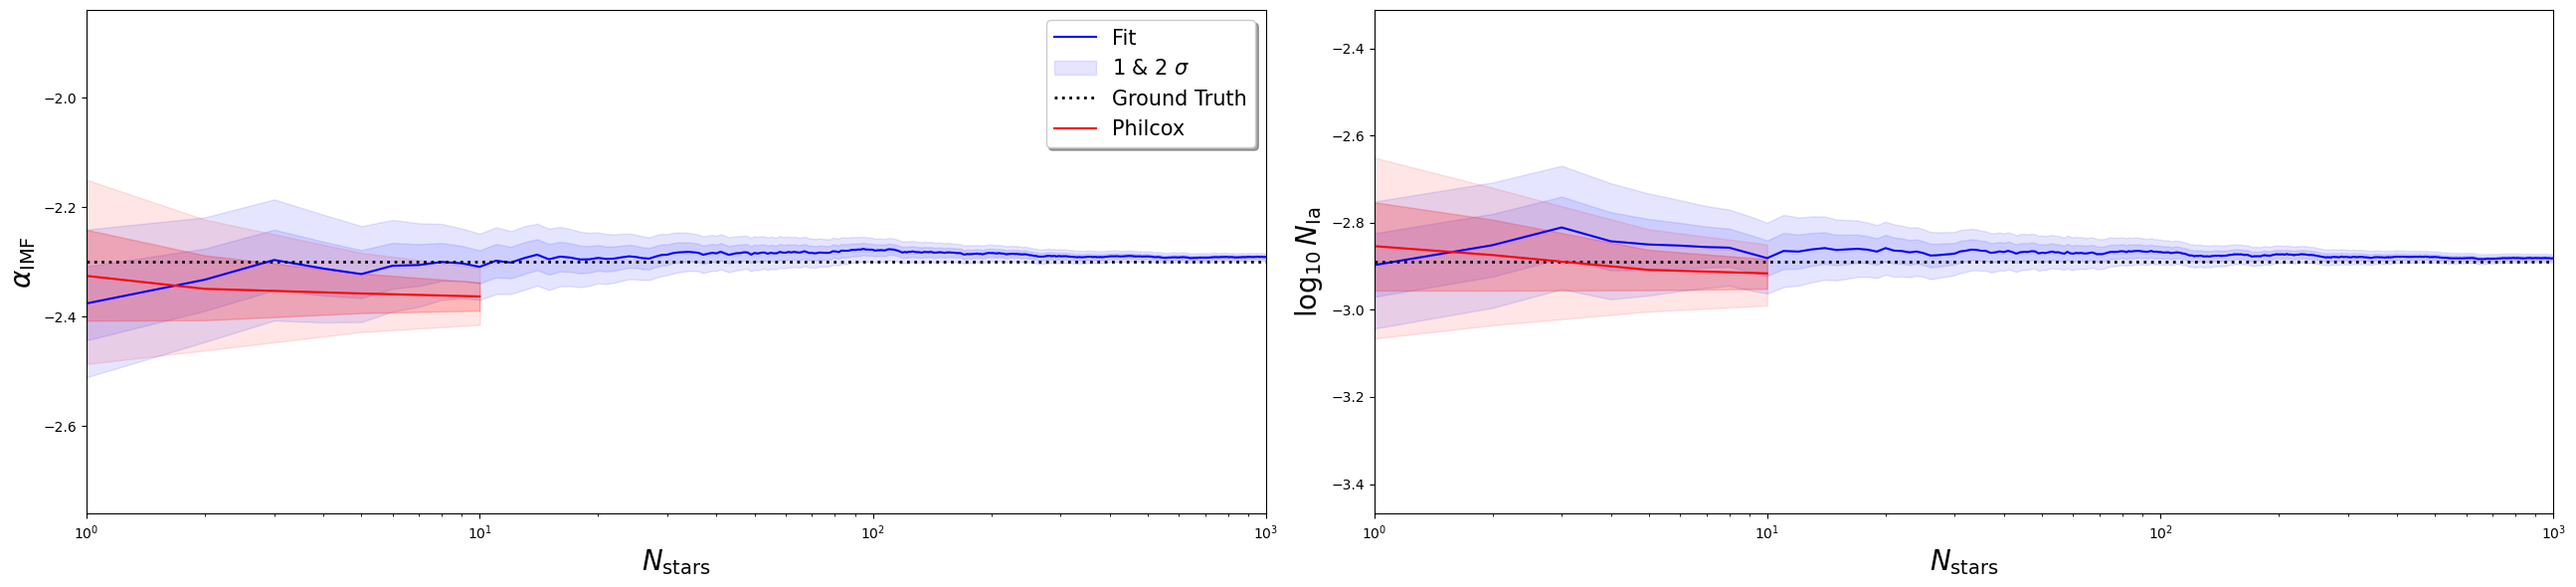

In [8]:
stars = np.arange(1,1000)
n_stars_plot_comp(alpha_IMF_obs, log10_N_Ia_obs, global_params[0], stars)